<a href="https://colab.research.google.com/github/StephenSheng1101/DMAsgmnt/blob/main/Ridge%20Regression%20Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ridge Regression**


**Data Preprocessing before begin with Ridge Regression**

In [18]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler

In [19]:
transport = pd.read_csv("dataset.csv")
transport.describe()
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518361 entries, 0 to 518360
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              518361 non-null  object 
 1   travel_fee      518361 non-null  float64
 2   departure_time  518361 non-null  object 
 3   departure_long  518361 non-null  float64
 4   departure_lat   518360 non-null  float64
 5   arrival_long    518355 non-null  float64
 6   arrival_lat     518355 non-null  float64
 7   occupancy       518360 non-null  float64
dtypes: float64(6), object(2)
memory usage: 31.6+ MB


In [20]:
transport.isnull().sum()

ID                0
travel_fee        0
departure_time    0
departure_long    0
departure_lat     1
arrival_long      6
arrival_lat       6
occupancy         1
dtype: int64

In [21]:
#handling missing value
transport["departure_long"].fillna(transport["departure_long"].mean(), inplace=True)
transport["departure_lat"].fillna(transport["departure_lat"].mean(), inplace=True)
transport["occupancy"].fillna(transport["occupancy"].mode()[0], inplace=True)
transport.drop(columns=['ID'], inplace=True)

# Drop rows with missing "departure_time","arrival_long" and "arrival_lat"
transport.dropna(subset=["departure_time", "arrival_long", "arrival_lat"],inplace = True)
transport.isnull().sum()

# Drop rows with a 0 value of occupancy
transport = transport.drop(transport[transport['occupancy'] <= 0].index)

In [22]:
transport.head()

,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [23]:
# Convert departure_time to datetime
transport['departure_time'] = pd.to_datetime(transport['departure_time'])

# Extract features from departure_time
transport['hour_of_day'] = transport['departure_time'].dt.hour
transport['day_of_week'] = transport['departure_time'].dt.dayofweek

In [24]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(transport.head(500000), test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 400000
Length of test_set: 100000


In [25]:
travelfee = train_set.drop("travel_fee", axis=1)
travelfee_labels = train_set["travel_fee"].copy()

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = [ 'departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'hour_of_day', 'day_of_week','occupancy']

num_pipeline = make_pipeline(
    StandardScaler()  # Scale features
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    # Apply numeric pipeline to numeric attributes
])

In [27]:
transport_prepared = preprocessing.fit_transform(transport)
transport_prepared

array([[-0.13931881,  0.10647871, -0.14192551, ...,  0.83893616,
        -1.0421306 , -0.51550673],
       [-0.14010939,  0.10429268, -0.14258114, ..., -2.06195121,
         1.00215009, -0.51550673],
       [-0.13803618,  0.10993284, -0.13593987, ..., -1.60391636,
         1.51322026, -0.51550673],
       ...,
       [-0.1272348 ,  0.11141532, -0.13899496, ..., -0.68784667,
        -0.01999025,  2.39782439],
       [-0.13549651,  0.11020876, -0.13904167, ...,  1.14429273,
        -0.01999025,  3.12615717],
       [-0.13854644,  0.10797896, -0.13914209, ...,  0.68625788,
         1.51322026, -0.51550673]])

**Select and Train a Model on the Prepared Training Set**

**Ridge Regression**

Ridge Regression is a regularization technique used to prevent overfitting in linear regression models by adding a penalty term to the cost function based on the L2 norm of the coefficients. Let's continue with implementing Ridge Regression the preprocessed data.

In [28]:
#Imported necessary libraries and modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics.pairwise import euclidean_distances

In [29]:
# Define features (X) and target variable (y)
X = transport_prepared[:, 1:]  # Exclude the 'travel_fee' column
y = transport_prepared[:, 0]   # Use the 'travel_fee' column as the target variable


In [30]:
# Define different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [31]:
# Create an empty dictionary to store RMSE scores for each alpha
rmse_scores_dict = {}

In [32]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# Iterate through each alpha value
for alpha in alphas:
    # Create a Ridge Regression model with the current alpha
    model = Ridge(alpha=alpha)

    # Perform K-fold cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error'))

    # Store the RMSE scores in the dictionary
    rmse_scores_dict[alpha] = rmse_scores

In [34]:
# Convert the dictionary into a DataFrame for easier analysis
rmse_df = pd.DataFrame(rmse_scores_dict)

In [35]:
# Calculate the mean RMSE and standard deviation for each alpha
rmse_mean = rmse_df.mean()
rmse_std = rmse_df.std()

In [36]:
# Find the alpha with the lowest mean RMSE
best_alpha = rmse_mean.idxmin()

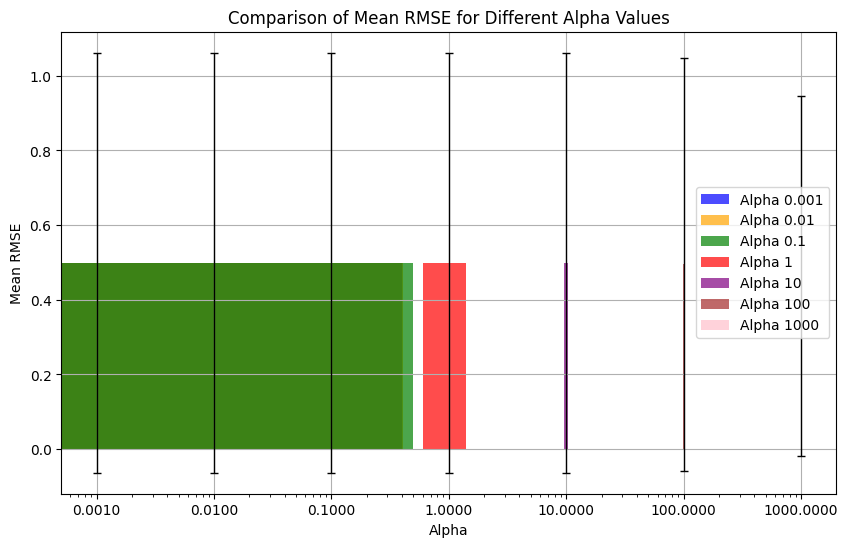

Mean RMSE for each alpha:
0.0010000000: 0.4991663695
0.0100000000: 0.4991659970
0.1000000000: 0.4991622715
1.0000000000: 0.4991250232
10.0000000000: 0.4987531581
100.0000000000: 0.4950953278
1000.0000000000: 0.4637544782

Standard Deviation of RMSE for each alpha:
0.0010000000: 0.5625634606
0.0100000000: 0.5625626232
0.1000000000: 0.5625542498
1.0000000000: 0.5624705297
10.0000000000: 0.5616346981
100.0000000000: 0.5534111375
1000.0000000000: 0.4827768417

Best alpha: 1000.0


In [37]:
# Define colors for each bar
bar_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

# Visualize the comparison between each alpha outcome using a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(alphas, rmse_mean, yerr=rmse_std, align='center', capsize=5, color=bar_colors, alpha=0.7, error_kw={'elinewidth': 1, 'capsize': 3})
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Alpha')
plt.ylabel('Mean RMSE')
plt.title('Comparison of Mean RMSE for Different Alpha Values')
plt.xticks(alphas, ['{:.4f}'.format(a) for a in alphas])  # Set x-axis ticks to the specified alpha values
plt.grid(True)
plt.legend(bars, ['Alpha ' + str(a) for a in alphas])  # Add legend
plt.show()

print("Mean RMSE for each alpha:")
for alpha, mean_rmse in zip(alphas, rmse_mean):
    print("{:.10f}: {:.10f}".format(alpha, mean_rmse))

print("\nStandard Deviation of RMSE for each alpha:")
for alpha, std_rmse in zip(alphas, rmse_std):
    print("{:.10f}: {:.10f}".format(alpha, std_rmse))

print("\nBest alpha:", best_alpha)

# Fine-tune Ridge Regression model (shortlisted promising models) using crossvalidation.


In [38]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to search through
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a Ridge Regression model
ridge_model = Ridge()

# Initialize GridSearchCV with Ridge model and parameter grid
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the data
grid_search.fit(X, y)

# Get the best alpha value and associated RMSE score
best_alpha = grid_search.best_params_['alpha']
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best alpha:", best_alpha)
print("Best RMSE:", best_rmse)

Best alpha: 1000
Best RMSE: 0.6363600545668121
